In [505]:
import scrapy
import requests
from bs4 import BeautifulSoup
from scrapy import Selector
import pandas as pd
import seaborn as sns
import numpy as np
import re
from datetime import datetime, timedelta

In [506]:
leagues = requests.get("https://www.soccerstats.com/leagues.asp")

leagues_sel = Selector(leagues)

links = leagues_sel.xpath("//a/@href").extract()

urls = ["https://www.soccerstats.com/" + link for link in links if link[0:6] == "latest"]

base_urls = [url.replace("latest", "formtable") for url in urls]

rp_urls = [url.replace("latest", "table") + "&tid=rp" for url in urls]

In [507]:
def parse_html(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    result_elems = soup.find_all(class_="trow8")
    
    return result_elems

In [508]:
def extract_data(result_elems):

        index_start = 0
        number_of_elements = len(result_elems)
        index_end = int(number_of_elements / 6)
        increments = int(number_of_elements / 6)

        league_table = pd.DataFrame([result.text.strip("\n").split("\n") for result in result_elems[index_start:index_end]], columns=["Team", "Played", "Missing", "Result"]).drop(["Missing"], axis=1)

        index_start += increments
        index_end += increments

        form_table = pd.DataFrame([result.text.strip("\n").split("\n") for result in result_elems[index_start:index_end]], columns=["Team", "Played", "Missing", "Result"]).drop(["Missing"], axis=1) 

        index_start += increments
        index_end += increments

        home_table = pd.DataFrame([result.text.strip("\n").split("\n") for result in result_elems[index_start:index_end]], columns=["Team", "Played", "Missing", "Result"]).drop(["Missing"], axis=1)

        index_start += increments
        index_end += increments

        away_table = pd.DataFrame([result.text.strip("\n").split("\n") for result in result_elems[index_start:index_end]], columns=["Team", "Played", "Missing", "Result"]).drop(["Missing"], axis=1)

        index_start += increments
        index_end += increments

        goals_scored = pd.DataFrame([result.text.strip("\n").split("\n") for result in result_elems[index_start:index_end]], columns=["Team", "Played", "Missing", "Result"]).drop(["Missing"], axis=1)

        index_start += increments
        index_end += increments

        goals_conceded = pd.DataFrame([result.text.strip("\n").split("\n") for result in result_elems[index_start:index_end]], columns=["Team", "Played", "Missing", "Result"]).drop(["Missing"], axis=1)

        return league_table, form_table, home_table, away_table, goals_scored, goals_conceded
    

In [509]:
def build_dataset(league_table, form_table, home_table, away_table, goals_scored, goals_conceded):
    dataset = {}

    for team in league_table["Team"]:
        
        if (league_table.loc[league_table["Team"] == team, "Played"].values == "0" or 
            home_table.loc[home_table["Team"] == team, "Played"].values == "0" or
            away_table.loc[away_table["Team"] == team, "Played"].values == "0"):
            dataset[team] = {"ppg": 0,
                             "recent_ppg": 0,
                             "home_ppg": 0,
                             "away_ppg": 0,
                             "goals_scored": 0,
                             "goals_conceded": 0
                            }
        else:
            dataset[team] = {"ppg": int(league_table[league_table["Team"] == team]["Result"]) / int(league_table[league_table["Team"] == team]["Played"]),
                             "recent_ppg": int(form_table[form_table["Team"] == team]["Result"]) / int(form_table[form_table["Team"] == team]["Played"]),
                             "home_ppg": int(home_table[home_table["Team"] == team]["Result"]) / int(home_table[home_table["Team"] == team]["Played"]),
                             "away_ppg": int(away_table[away_table["Team"] == team]["Result"]) / int(away_table[away_table["Team"] == team]["Played"]),
                             "goals_scored": int(goals_scored[goals_scored["Team"] == team]["Result"]) / int(goals_scored[goals_scored["Team"] == team]["Played"]),
                             "goals_conceded": int(goals_conceded[goals_conceded["Team"] == team]["Result"]) / int(goals_conceded[goals_conceded["Team"] == team]["Played"])
                            }

    return dataset

In [510]:
def predict_result(sims, dataset, home_team, away_team):
    
    home_wins = 0
    away_wins = 0
    draw = 0
    
    for i in range(sims):
        home_score = np.random.poisson(dataset[home_team]["recent_ppg"])
        away_score = np.random.poisson(dataset[away_team]["recent_ppg"])
        
        if home_score > away_score:
            home_wins += 1
            
        elif away_score > home_score:
            away_wins += 1
            
        else:
            draw += 1
            
    return (home_wins / sims, away_wins / sims, draw / sims)

In [511]:
def fixture_builder(results_dataframe, home_team, away_team):
    
    home_team_data = results_dataframe.loc[[home_team], :].reset_index().drop(["index"], axis=1)
    home_team_data.columns = [column + "_home_team" for column in results_dataframe.columns.values]
    
    away_team_data = results_dataframe.loc[[away_team], :].reset_index().drop(["index"], axis=1)
    away_team_data.columns = [column + "_away_team" for column in results_dataframe.columns.values]
    
    fixture = pd.concat([home_team_data, away_team_data], axis=1)
    
    return fixture

In [512]:
def extract_oppg(url):
    relative_performance = requests.get(url)
    
    rp_selector = Selector(relative_performance)
    
    oppg_values = _extract_oppg_value(rp_selector)
    
    oppg_teams = _extract_oppg_teams(rp_selector)
    
    oppg = {}

    for oppg_team, oppg_value in zip(oppg_teams, oppg_values):
        oppg[oppg_team] = {"oppg": oppg_value} 
        
        
    oppg_df = pd.DataFrame.from_dict(oppg, orient="index")
        
    return oppg_df

In [513]:
def _extract_oppg_value(selector):
    opponent_ppg = selector.xpath('//a[@class="tooltip2"]//b').extract()

    all_oppg = []

    for oppg in opponent_ppg:
        result = re.sub('\D', '', oppg)
        if len(result) == 0:
            pass
        else:
            all_oppg.append(float(result) / 100)
            
    return all_oppg

In [514]:
def _extract_oppg_teams(selector):
    rp_teams = selector.xpath("//td//a/@title").extract()
    
    teams_oppg = []

    for rp_team in rp_teams:
        if " stats" in rp_team:
            teams_oppg.append(rp_team.split(" stats")[0])
            
    return teams_oppg

In [515]:
oppg_results = pd.DataFrame(columns=["oppg"])

for url in rp_urls:
    print(f"extracting results for {url}")
    try:
        df = extract_oppg(url)
        oppg_results = pd.concat([oppg_results, df], axis=0)
    except(ValueError):
        print(f"unable to extract results for {url}")
        


extracting results for https://www.soccerstats.com/table.asp?league=argentina&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=austria&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=australia&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=belgium&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=brazil&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=switzerland&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=czechrepublic&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=germany&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=germany2&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=denmark&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=england&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=engla

extracting results for https://www.soccerstats.com/table.asp?league=bulgaria&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=bulgaria2&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=cameroon&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=cameroon2&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=canada&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=chile&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=chile2&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=chile3&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=china&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=china2&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=colombia&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=colombia2&tid=rp
ext

extracting results for https://www.soccerstats.com/table.asp?league=germany23&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=ghana&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=gibraltar&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=greece&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=greece2&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=greece3&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=guatemala&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=guatemala2&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=honduras&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=honduras2&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=hongkong&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=hungary&t

extracting results for https://www.soccerstats.com/table.asp?league=norway12&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=oman&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=palestine&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=panama&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=panama2&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=paraguay&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=paraguay2&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=paraguay3&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=peru&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=peru2&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=peru3&tid=rp
extracting results for https://www.soccerstats.com/table.asp?league=peru4&tid=rp
extractin

extracting results for https://www.soccerstats.com/table.asp?league=zambia&tid=rp


In [516]:
oppg_results['team'] = oppg_results.index
oppg_results = oppg_results.drop_duplicates()
oppg_results = oppg_results[~oppg_results.index.duplicated(keep='first')]
oppg_results = oppg_results.drop(['team'], axis=1)

In [517]:
all_results = {}

for url in base_urls:
    print(url)
    result_elems = parse_html(url)
    
    if len(result_elems) == 0:
        print("No results for " + url)
        pass
    
    try:
        league_table, form_table, home_table, away_table, goals_scored, goals_conceded = extract_data(result_elems)
    except(ValueError):
        print("Unable to parse data for " + url)

    dataset = build_dataset(league_table, form_table, home_table, away_table, goals_scored, goals_conceded)
    all_results.update(dataset)

https://www.soccerstats.com/formtable.asp?league=argentina
https://www.soccerstats.com/formtable.asp?league=austria
https://www.soccerstats.com/formtable.asp?league=australia
https://www.soccerstats.com/formtable.asp?league=belgium
https://www.soccerstats.com/formtable.asp?league=brazil
https://www.soccerstats.com/formtable.asp?league=switzerland
https://www.soccerstats.com/formtable.asp?league=czechrepublic
https://www.soccerstats.com/formtable.asp?league=germany
https://www.soccerstats.com/formtable.asp?league=germany2
https://www.soccerstats.com/formtable.asp?league=denmark
https://www.soccerstats.com/formtable.asp?league=england
https://www.soccerstats.com/formtable.asp?league=england2
https://www.soccerstats.com/formtable.asp?league=england3
https://www.soccerstats.com/formtable.asp?league=england4
https://www.soccerstats.com/formtable.asp?league=england5
https://www.soccerstats.com/formtable.asp?league=spain
https://www.soccerstats.com/formtable.asp?league=spain2
https://www.socc

https://www.soccerstats.com/formtable.asp?league=england12
https://www.soccerstats.com/formtable.asp?league=england13
https://www.soccerstats.com/formtable.asp?league=england14
https://www.soccerstats.com/formtable.asp?league=england15
https://www.soccerstats.com/formtable.asp?league=england16
https://www.soccerstats.com/formtable.asp?league=england17
https://www.soccerstats.com/formtable.asp?league=england18
https://www.soccerstats.com/formtable.asp?league=england19
https://www.soccerstats.com/formtable.asp?league=estonia
https://www.soccerstats.com/formtable.asp?league=estonia2
https://www.soccerstats.com/formtable.asp?league=faroeislands
https://www.soccerstats.com/formtable.asp?league=faroeislands2
https://www.soccerstats.com/formtable.asp?league=finland
https://www.soccerstats.com/formtable.asp?league=finland2
https://www.soccerstats.com/formtable.asp?league=finland3
https://www.soccerstats.com/formtable.asp?league=finland4
https://www.soccerstats.com/formtable.asp?league=finland5

https://www.soccerstats.com/formtable.asp?league=nicaragua4
https://www.soccerstats.com/formtable.asp?league=nigeria
https://www.soccerstats.com/formtable.asp?league=northernireland
https://www.soccerstats.com/formtable.asp?league=northernireland2
https://www.soccerstats.com/formtable.asp?league=northernireland3
https://www.soccerstats.com/formtable.asp?league=northmacedonia
https://www.soccerstats.com/formtable.asp?league=northmacedonia2
https://www.soccerstats.com/formtable.asp?league=norway
https://www.soccerstats.com/formtable.asp?league=norway2
https://www.soccerstats.com/formtable.asp?league=norway3
https://www.soccerstats.com/formtable.asp?league=norway4
https://www.soccerstats.com/formtable.asp?league=norway11
https://www.soccerstats.com/formtable.asp?league=norway12
https://www.soccerstats.com/formtable.asp?league=oman
https://www.soccerstats.com/formtable.asp?league=palestine
https://www.soccerstats.com/formtable.asp?league=panama
https://www.soccerstats.com/formtable.asp?lea

In [518]:
results = pd.DataFrame.from_dict(all_results, orient="index")

In [519]:
results = results.merge(oppg_results, how="left", left_index=True, right_index=True)

In [520]:
todays_matches = requests.get("https://www.soccerstats.com/matches.asp?matchday=1")
match_soup = BeautifulSoup(todays_matches.content, "html.parser")

matches_today = match_soup.find_all(class_="steam")

In [521]:
match_home_team = []
match_away_team = []

for i in range(len(matches_today)):
    if i % 2 == 0:
        match_home_team.append(matches_today[i].text)
    else:
        match_away_team.append(matches_today[i].text)

In [522]:
todays_fixtures = pd.DataFrame(columns = ['ppg_home_team', 'recent_ppg_home_team', 'home_ppg_home_team',
 'away_ppg_home_team', 'goals_scored_home_team', 'goals_conceded_home_team', 'oppg_home_team',
 'ppg_away_team', 'recent_ppg_away_team', 'home_ppg_away_team',
 'away_ppg_away_team', 'goals_scored_away_team', 'goals_conceded_away_team', 'oppg_away_team'])

index = []
bad_results = []
i = 0

for home_team, away_team in zip(match_home_team, match_away_team):
    if home_team in results.index and away_team in results.index:
        result = fixture_builder(results, home_team, away_team)
        todays_fixtures = pd.concat([todays_fixtures, result], ignore_index=True)
        index.append(home_team + " vs " + away_team)
    else:
        bad_results.append(f"Unable to build result for {home_team} vs {away_team}")
        
todays_fixtures.index = index

In [523]:
dt = datetime.today().strftime('%Y-%m-%d')

todays_fixtures.to_csv("/Users/sam/Documents/projects/premier_league_predictions/data/" + str(dt) + "_fixtures.csv")

In [524]:
results_yesterday = requests.get("https://www.soccerstats.com/matches.asp?matchday=0&daym=yesterday")

sel = Selector(results_yesterday)

high_level = sel.xpath("//tr[@height=18]/td[@class='steam']/text()").extract()

scores = sel.xpath("//tr[@height=18]/td[2]").extract()

In [525]:
matchday_scores = []

for score in scores:
    if score.find("<b>(.+?)</b>"):
        try:
            matchday_scores.append(re.search("<b>(.+?)</b>", score).group(1))
        except(AttributeError):
            matchday_scores.append("pp")
    else:
        print("pp")

In [526]:
scores_home_team = []
scores_away_team = []

for i in range(len(matchday_scores)):
    if i % 2 == 0:
        scores_home_team.append(matchday_scores[i])
    else:
        scores_away_team.append(matchday_scores[i])

In [527]:
match_result = []

for home, away in zip(scores_home_team, scores_away_team):
    try:
        if int(home) > int(away):
            match_result.append("home")
        if int(away) > int(home):
            match_result.append("away")
        if int(home) == int(away):
            match_result.append("draw")
    except(ValueError):
        match_result.append("pp")

In [528]:
result_home_team = []
result_away_team = []

for i in range(len(high_level)):
    if i % 2 == 0:
        result_home_team.append(high_level[i])
    else:
        result_away_team.append(high_level[i])

In [529]:
ind = []

for home, away in zip(result_home_team, result_away_team):
    ind.append(home + " vs " + away)

In [530]:
yesterdays_results = pd.DataFrame(match_result, columns=["result"])

In [531]:
yesterdays_results.index = ind

In [532]:
yesterdays_results

,result
Brighton vs Swansea City,home
Arsenal vs AFC Wimbledon,home
Chelsea vs Aston Villa,draw
Manchester Utd vs West Ham Utd,away
Millwall vs Leicester City,away
...,...
Green Eagles vs Lusaka Dynamos,draw
Kafue Celtic vs Indeni,away
Kansanshi Dynam vs Kabwe Warriors,home
Konkola Blades vs Nkwazi,away


In [533]:
yesterday = datetime.now() - timedelta(1)
   
yesterday = datetime.strftime(yesterday, '%Y-%m-%d')

In [534]:
try:
    yesterdays_fixtures = pd.read_csv("/Users/sam/Documents/projects/premier_league_predictions/data/" + yesterday + "_fixtures.csv", index_col=0)

    yesterdays_fixtures = pd.merge(yesterdays_fixtures, yesterdays_results, left_index=True, right_index=True, how="left")
    
    yesterdays_fixtures.to_csv("/Users/sam/Documents/projects/premier_league_predictions/data/" + str(yesterday) + "_fixtures.csv")
except(FileNotFoundError):
    print(f"Unable to find csv for {yesterday}")

In [535]:
week_31_fixtures = pd.DataFrame(columns = ['ppg_home_team', 'recent_ppg_home_team', 'home_ppg_home_team',
 'away_ppg_home_team', 'goals_scored_home_team', 'goals_conceded_home_team', 'oppg_home_team',
 'ppg_away_team', 'recent_ppg_away_team', 'home_ppg_away_team',
 'away_ppg_away_team', 'goals_scored_away_team', 'goals_conceded_away_team', 'oppg_away_team'])

week_31_home = ['Chelsea',
'Everton',
'Leeds Utd',
'Leicester City',
'Manchester Utd',
'Watford',
'Brentford',
'Southampton',
'Arsenal',
'Blackburn']

week_31_away = ['Manchester C.',
'Norwich City',
'West Ham Utd',
'Burnley',
'Aston Villa',
'Newcastle Utd',
'Liverpool',
'Wolverhampton',
'Tottenham',
'Cardiff City']

rows = []
index = []

for current_week_home, current_week_away in zip(week_31_home, week_31_away):
    rows.append(fixture_builder(results, current_week_home, current_week_away))
    index.append(current_week_home + " vs " + current_week_away)
    
for row in rows:
    week_31_fixtures = week_31_fixtures.append(row)
        
week_31_fixtures.index=index

In [536]:
week_31_fixtures

,ppg_home_team,recent_ppg_home_team,home_ppg_home_team,away_ppg_home_team,goals_scored_home_team,goals_conceded_home_team,oppg_home_team,ppg_away_team,recent_ppg_away_team,home_ppg_away_team,away_ppg_away_team,goals_scored_away_team,goals_conceded_away_team,oppg_away_team
Chelsea vs Manchester C.,2.600,2.600,3.00,2.333333,2.400,0.2,1.23,2.000,2.000,2.333333,1.50,2.200,0.200,NaN
Everton vs Norwich City,2.000,2.000,3.00,1.333333,2.000,1.4,1.10,0.000,0.000,0.000000,0.00,0.400,2.800,1.77
Leeds Utd vs West Ham Utd,0.600,0.600,0.50,0.666667,1.000,2.4,1.67,1.600,1.600,1.333333,2.00,2.200,1.400,1.07
Leicester City vs Burnley,1.200,1.200,1.50,1.000000,1.000,1.6,1.27,0.200,0.200,0.333333,0.00,0.600,1.800,2.00
Manchester Utd vs Aston Villa,2.600,2.600,3.00,2.333333,2.600,0.8,0.60,1.400,1.400,2.333333,0.00,1.600,1.400,1.50
Watford vs Newcastle Utd,1.200,1.200,1.50,1.000000,1.200,1.6,1.10,0.400,0.400,0.666667,0.00,1.200,2.600,1.73
Brentford vs Liverpool,1.600,1.600,1.50,1.666667,1.000,0.4,1.67,2.600,2.600,2.333333,3.00,2.400,0.200,0.63
Southampton vs Wolverhampton,0.800,0.800,1.00,0.666667,0.800,1.2,2.07,0.600,0.600,0.000000,1.50,0.400,1.000,1.70
Arsenal vs Tottenham,1.200,1.200,1.50,1.000000,0.400,1.8,1.30,1.800,1.800,2.000000,1.50,0.600,1.200,1.37
Blackburn vs Cardiff City,1.625,1.625,1.75,1.500000,1.375,1.0,1.09,1.375,1.375,1.000000,1.75,1.375,1.125,1.47


In [537]:
week_31_fixtures.to_csv("/Users/sam/Documents/projects/premier_league_predictions/current_gameweek.csv")

In [538]:
550 / 40

13.75

In [539]:
week = list(range(1, 41, 1))
rr = list(range(0, 550, 14))
scores =  [12, 15]

In [540]:
rr

[0,
 14,
 28,
 42,
 56,
 70,
 84,
 98,
 112,
 126,
 140,
 154,
 168,
 182,
 196,
 210,
 224,
 238,
 252,
 266,
 280,
 294,
 308,
 322,
 336,
 350,
 364,
 378,
 392,
 406,
 420,
 434,
 448,
 462,
 476,
 490,
 504,
 518,
 532,
 546]

<AxesSubplot:>

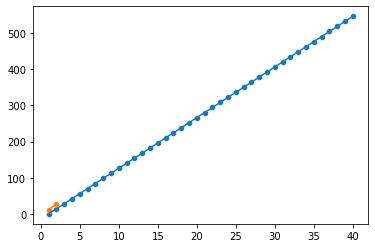

In [541]:
sns.scatterplot(x=week, y=rr)
sns.lineplot(x=week, y=rr)
sns.scatterplot(x=list(range(1, len(scores) + 1)), y=np.cumsum(scores))
sns.lineplot(x=list(range(1, len(scores) + 1)), y=np.cumsum(scores))